author: @SteveEckel

This example covers calculating the forces in a one-dimensional MOT using the
optical bloch equations.  This example does the boring thing and checks that
everything is working on the $F=0 \rightarrow F'=1$ transition.

It first checks the force along the $\hat{z}$-direction.  One should look to see that
things agree with what one expects whether or not one puts the detuning on
the lasers or on the Hamilonian.  One should also look at whether the force
depends on transforming the OBEs into the real/imaginary components.

It then checks the force along the $\hat{x}$ and $\hat{y}$ directions.  This is important
because the OBEs solve this in a different way compared to the rate equations.
Whereas the rate equatons rediagonalize the Hamiltonian for a given direction,
the OBE solves everything in the $\hat{z}$-basis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.tools
import time
from scipy.optimize import fsolve
plt.style.use('paper')

### Define the multiple laser beam configurations to start
Along with the Hamiltonian and magnetic field. 

In [2]:
laser_det = 0
ham_det = -2.5
beta = 1.
transform = True

laserBeams = {}
laserBeams['x'] = pylcp.laserBeams([
    {'kvec':np.array([ 1., 0., 0.]), 'pol':-1, 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([-1., 0., 0.]), 'pol':-1, 'delta':laser_det, 'beta':beta},
    ], beam_type=pylcp.infinitePlaneWaveBeam)
laserBeams['y'] = pylcp.laserBeams([
    {'kvec':np.array([0.,  1., 0.]), 'pol':-1, 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':laser_det, 'beta':beta}
    ], beam_type=pylcp.infinitePlaneWaveBeam)
laserBeams['z'] = pylcp.laserBeams([
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det, 'beta':beta},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det, 'beta':beta}
    ], beam_type=pylcp.infinitePlaneWaveBeam)

alpha = 1e-3
magField = pylcp.quadrupoleMagneticField(alpha)

# Hamiltonian for F=0->F=1
H_g, muq_g = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
H_e, muq_e = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1)
d_q = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
hamiltonian = pylcp.hamiltonian(H_g, H_e - ham_det*np.eye(3), muq_g, muq_e, d_q)

### First, check to see that the rate equations and OBE agree:

In [3]:
obe={}
rateeq={}

obe['z'] = {}
rateeq['z'] = {}

z = np.arange(-5.0, 5.01, 0.25)

rateeq['z'] = pylcp.rateeq(laserBeams['z'], magField, hamiltonian)
rateeq['z'].generate_force_profile(
    [np.zeros(z.shape), np.zeros(z.shape), z/alpha],
    np.zeros((3,) + z.shape),
    name='MOT_1'
)

obe['z'] = pylcp.obe(laserBeams['z'], magField, hamiltonian,
                     transform_into_re_im=transform,
                     include_mag_forces=True)
obe['z'].generate_force_profile(
    [np.zeros(z.shape), np.zeros(z.shape), z/alpha],
    np.zeros((3,) + z.shape),
    name='MOT_1', deltat_tmax=2*np.pi*100, deltat_r=4/alpha,
    itermax=1000, progress_bar=True
)

Completed in 7.80 s.                                               


Plot 'er up:

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


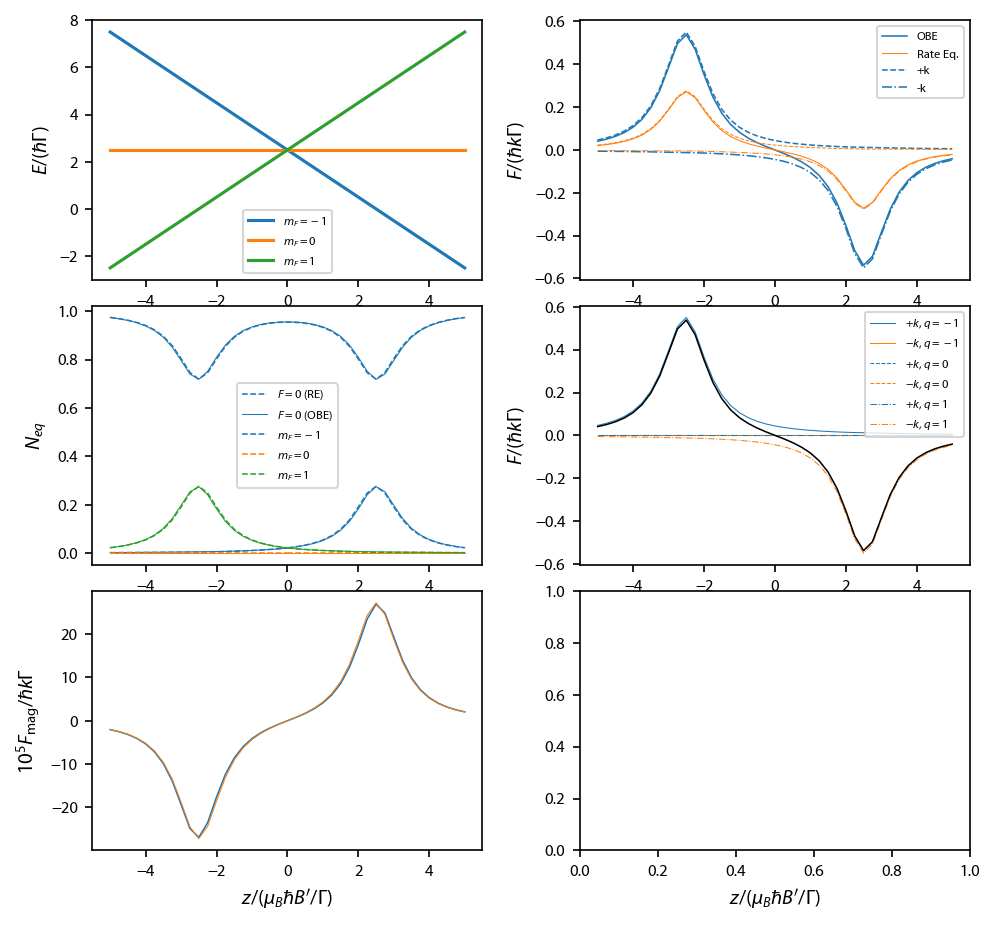

In [4]:
fig, ax = plt.subplots(3, 2, num='Optical Molasses F=0->F1', figsize=(6.5, 3*2.25))

Es = np.zeros((z.size, 4))
for ii, z_i in enumerate(z):
    Bq = np.array([0., magField.Field(np.array([0., 0., z_i/alpha]))[2], 0])
    Es[ii, :] = np.diag(hamiltonian.return_full_H({'g->e':np.array([0., 0., 0.])}, Bq))

[ax[0, 0].plot(z, Es[:, 1+jj], label='$m_F=%d$'%(jj-1)) for jj in range(3)]
ax[0, 0].legend(fontsize=6)
ax[0, 0].set_ylabel('$E/(\hbar \Gamma)$')

types = ['-', '--', '-.']
lbls = ['+k','-k']
ax[0, 1].plot(obe['z'].profile['MOT_1'].R[2]*alpha,
           obe['z'].profile['MOT_1'].F[2],
           label='OBE', linewidth=0.75)
ax[0, 1].plot(rateeq['z'].profile['MOT_1'].R[2]*alpha,
           rateeq['z'].profile['MOT_1'].F[2],
           label='Rate Eq.', linewidth=0.5)
for jj in range(2):
    ax[0, 1].plot(obe['z'].profile['MOT_1'].R[2]*alpha,
                  obe['z'].profile['MOT_1'].f['g->e'][2, :, jj],
                  types[jj+1], color='C0', linewidth=0.75, label=lbls[jj])
    ax[0, 1].plot(rateeq['z'].profile['MOT_1'].R[2]*alpha,
                  rateeq['z'].profile['MOT_1'].f['g->e'][2, :, jj],
                  types[jj+1], color='C1', linewidth=0.5)
ax[0, 1].legend(fontsize=6)
ax[0, 1].set_ylabel('$F/(\hbar k \Gamma)$')

for q in range(3):
    ax[1, 1].plot(z, obe['z'].profile['MOT_1'].fq['g->e'][2, :, q, 0], types[q],
            linewidth=0.5, color='C0', label='$+k$, $q=%d$'%(q-1))
    ax[1, 1].plot(z, obe['z'].profile['MOT_1'].fq['g->e'][2, :, q, 1], types[q],
            linewidth=0.5, color='C1', label='$-k$, $q=%d$'%(q-1))
ax[1, 1].plot(z, obe['z'].profile['MOT_1'].F[2], 'k-',
           linewidth=0.75)
ax[1, 1].legend(fontsize=6)
ax[1, 1].set_xlabel('$z/(\mu_B \hbar B\'/\Gamma)$')
ax[1, 1].set_ylabel('$F/(\hbar k \Gamma)$')
fig.subplots_adjust(wspace=0.15)

ax[1, 0].plot(z, rateeq['z'].profile['MOT_1'].Neq[:, 0], '--',
              linewidth=0.75, label='$F=0$ (RE)')
ax[1, 0].plot(z, obe['z'].profile['MOT_1'].Neq[:, 0], '-',
              linewidth=0.5, color='C0', label='$F=0$ (OBE)')
for jj in range(3):
    ind = z<=0
    ax[1, 0].plot(z[ind], rateeq['z'].profile['MOT_1'].Neq[ind, 3-jj], '--',
                  linewidth=0.75, color='C%d'%jj, label='$m_F=%d$'%(jj-1))
    ind = z>=0
    ax[1, 0].plot(z[ind], rateeq['z'].profile['MOT_1'].Neq[ind, jj+1], '--',
                  linewidth=0.75, color='C%d'%jj)
    ax[1, 0].plot(z, obe['z'].profile['MOT_1'].Neq[:, jj+1], '-',
                  linewidth=0.5, color='C%d'%jj)

ax[1, 0].legend(fontsize=6)
ax[1, 0].set_ylabel('$N_{eq}$')

ax[2, 0].plot(z, 1e5*obe['z'].profile['MOT_1'].f_mag[2], linewidth=0.75)
ax[2, 0].plot(z, 1e5*rateeq['z'].profile['MOT_1'].f_mag[2], linewidth=0.5)
ax[2, 0].set_ylabel('$10^5F_{\\rm mag}/\hbar k \Gamma$')
ax[2, 0].set_xlabel('$z/(\mu_B \hbar B\'/\Gamma)$')
ax[2, 1].set_xlabel('$z/(\mu_B \hbar B\'/\Gamma)$')
fig.subplots_adjust(left=0.08, wspace=0.25)

### Let's now go along the x and y directions:

In [5]:
R = {}
R['x'] = [2*z/alpha, np.zeros(z.shape), np.zeros(z.shape)]
R['y'] = [np.zeros(z.shape), 2*z/alpha, np.zeros(z.shape)]

for key in ['x','y']:
    rateeq[key] = pylcp.rateeq(laserBeams[key], magField,
                               hamiltonian)
    rateeq[key].generate_force_profile(
        R[key], np.zeros((3,) + z.shape), name='MOT_1'
    )

    obe[key] = pylcp.obe(laserBeams[key], magField,  hamiltonian,
                         transform_into_re_im=transform,
                         include_mag_forces=False)

    obe[key].generate_force_profile(
        R[key], np.zeros((3,) + z.shape), name='MOT_1',
        deltat_tmax=2*np.pi*100, deltat_r=4/alpha, itermax=1000,
        progress_bar=True,
    )

Completed in 6.44 s.                                               
Completed in 6.21 s.                                               


Plot this one up:

Text(0, 0.5, '$F/(\\hbar k \\Gamma)$')

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


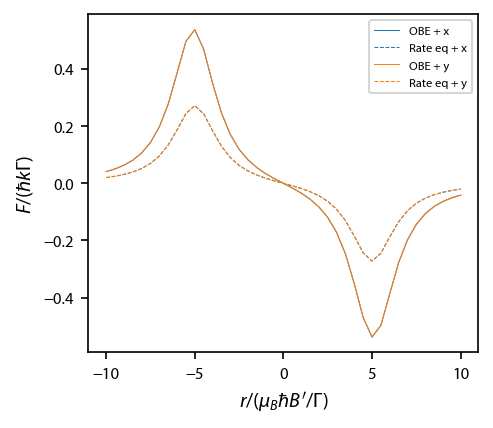

In [9]:
fig, ax = plt.subplots(1, 1)
for ii, key in enumerate(['x','y']):
    ax.plot(obe[key].profile['MOT_1'].R[ii]*alpha,
            obe[key].profile['MOT_1'].F[ii],
            label='OBE + %s' % key, color='C%d'%ii, linewidth=0.5)
    ax.plot(rateeq[key].profile['MOT_1'].R[ii]*alpha,
            rateeq[key].profile['MOT_1'].F[ii], '--',
            label='Rate eq + %s' % key, color='C%d'%ii, linewidth=0.5)
ax.legend(fontsize=6)
ax.set_xlabel('$r/(\mu_B \hbar B\'/\Gamma)$')
ax.set_ylabel('$F/(\hbar k \Gamma)$')

#fig.savefig('1D_MOT_OBE_x_and_y.pdf')

### Let's plop an atom in and see what happens:

In [8]:
for key in obe:
    if key is 'x':
        ii = 0
    elif key is 'y':
        ii = 1
    elif key is 'z':
        ii = 2

    r0 = np.zeros((3,))
    r0[ii] = 10.
    
    obe[key].set_initial_position(r0)
    obe[key].set_initial_velocity(np.zeros((3,)))
    obe[key].set_initial_rho_from_rateeq()
    
    freeze_axis = [True]*3
    freeze_axis[ii] = False
    
    obe[key].evolve_motion([0, 5e4],
                           freeze_axis=freeze_axis,
                           recoil_velocity=0.001,
                           progress_bar=True,
                           random_recoil=False
                          )

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `recoil_velocity`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


Completed in 1:56.                                                    
Completed in 1:43.                                                   
Completed in 1:41.                                                   


Text(0, 0.5, '$r=x,y,z$')

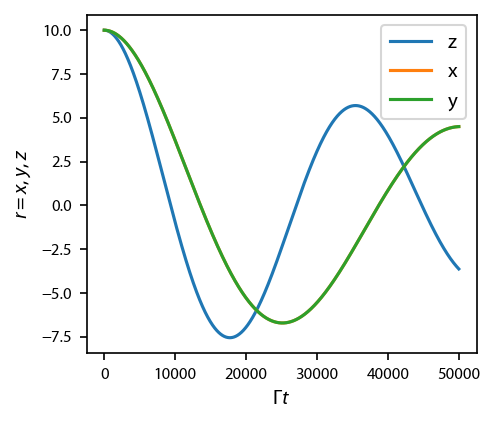

In [15]:
fig, ax = plt.subplots(1, 1)
for key in obe:
    if key is 'x':
        ii = 0
    elif key is 'y':
        ii = 1
    elif key is 'z':
        ii = 2
        
    ax.plot(obe[key].sol.t, obe[key].sol.r[ii], label=key)

ax.legend()
ax.set_xlabel('$\Gamma t$')
ax.set_ylabel('$r=x,y,z$')